<a href="https://colab.research.google.com/github/ucarols/Sprint-IA-IOT/blob/main/mottu_challenge_iot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção Real de Motos + OCR de Placa com YOLOv8
Este notebook usa YOLOv8 para detectar motos em uma imagem e aplica EasyOCR para identificar placas.

In [ ]:
# Instalar dependências
!pip install ultralytics easyocr opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8


0: 640x640 1 motorcycle, 434.9ms
Speed: 13.5ms preprocess, 434.9ms inference, 38.8ms postprocess per image at shape (1, 3, 640, 640)


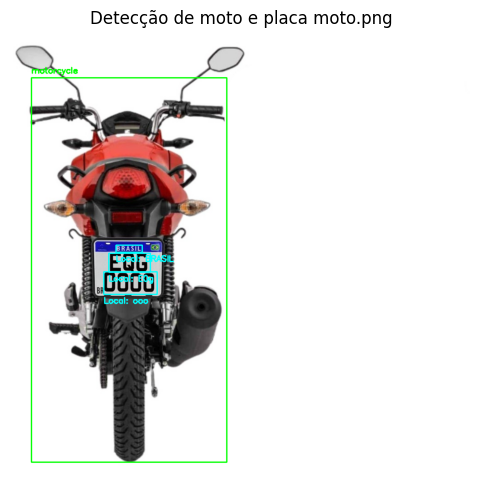


0: 320x640 1 motorcycle, 338.3ms
Speed: 6.6ms preprocess, 338.3ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)


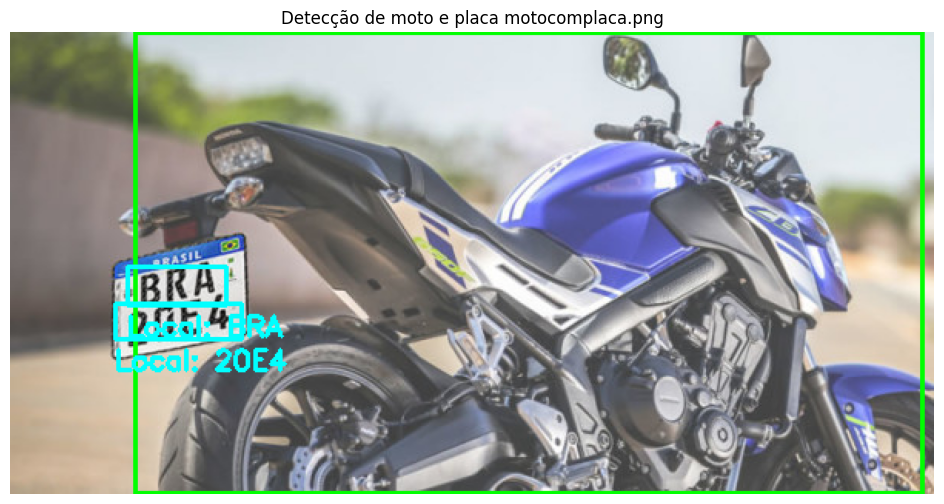

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
import easyocr
import re

# Carregar modelo YOLOv8
model = YOLO('yolov8n.pt')
reader = easyocr.Reader(['pt', 'en'], gpu=False)

# Lista de imagens a processar
img_path_list = ['moto.png', 'motocomplaca.png']

# Loop para processar todas as imagens
for img_path in img_path_list:
    img = cv2.imread(img_path)

    if img is None:
        print(f"Erro: Não foi possível carregar a imagem em {img_path}.")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = model(img_rgb)[0]

    #OCR GLOBAL COM FILTRO DE PADRÃO DE PLACA
    ocr_globais = reader.readtext(img)
    for (bbox, text, conf) in ocr_globais:
        text_clean = text.replace(" ", "").replace("-", "")
        if re.match(r"^[A-Z]{3}\d{1}[A-Z0-9]{1}\d{2}$", text_clean):
            (tl, tr, br, bl) = bbox
            tl = tuple(map(int, tl))
            br = tuple(map(int, br))
            cv2.rectangle(img_rgb, tl, br, (255, 0, 0), 2)
            cv2.putText(img_rgb, f"Placa Global: {text_clean}", (tl[0], tl[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    #DETECÇÃO DE MOTO + OCR LOCAL COM CAIXAS
    for box in results.boxes:
        cls = int(box.cls[0])
        label = model.names[cls]
        if label not in ['motorbike', 'motorcycle']:
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)

        #CROP EXPANDIDO PARA A REGIÃO DA PLACA
        offset_x = max(0, x1 - 30)
        offset_y = max(0, y1)
        placa_crop = img[offset_y:y2+20, offset_x:x2+30]

        #PRÉ-PROCESSAMENTO
        placa_gray = cv2.cvtColor(placa_crop, cv2.COLOR_BGR2GRAY)
        placa_filt = cv2.bilateralFilter(placa_gray, 11, 17, 17)
        _, placa_thresh = cv2.threshold(placa_filt, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        #OCR LOCAL MULTI-CAIXAS
        resultado_ocr = reader.readtext(placa_thresh)
        for (bbox, text, conf) in resultado_ocr:
            text_clean = text.replace(" ", "").replace("-", "")
            if len(text_clean) >= 3:
                (tl, tr, br, bl) = bbox
                tl_global = (int(tl[0] + offset_x), int(tl[1] + offset_y))
                br_global = (int(br[0] + offset_x), int(br[1] + offset_y))
                cv2.rectangle(img_rgb, tl_global, br_global, (0, 255, 255), 2)
                cv2.putText(img_rgb, f'Local: {text_clean}', (tl_global[0], br_global[1] + 20),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    #EXIBIR RESULTADO
    plt.figure(figsize=(12, 6))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f'Detecção de moto e placa {img_path}')
    plt.show()


In [ ]:
# Instalar dependências
!pip install opencv-python numpy


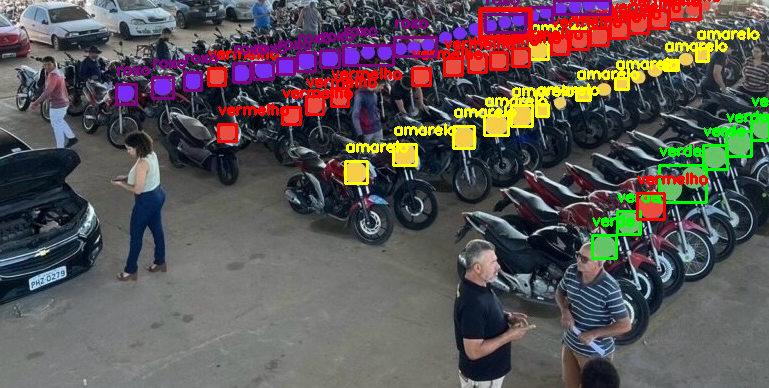

In [ ]:
import cv2
import numpy as np
from collections import defaultdict, Counter
from google.colab.patches import cv2_imshow

class MotoTracker:
    def __init__(self):
        self.color_ranges = {
            'verde': ([40, 50, 50], [80, 255, 255]),
            'amarelo': ([20, 100, 100], [30, 255, 255]),
            'vermelho': ([0, 100, 100], [10, 255, 255]),
            'roxo': ([130, 50, 50], [160, 255, 255])
        }

    def detectar_cores(self, frame):
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        resultados = []

        for cor, (lower, upper) in self.color_ranges.items():
            lower = np.array(lower, dtype=np.uint8)
            upper = np.array(upper, dtype=np.uint8)
            mask = cv2.inRange(hsv, lower, upper)
            mask = cv2.erode(mask, None, iterations=2)
            mask = cv2.dilate(mask, None, iterations=2)

            contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                if cv2.contourArea(cnt) > 100:
                    x, y, w, h = cv2.boundingRect(cnt)
                    centro = (x + w//2, y + h//2)
                    resultados.append({'cor': cor, 'centro': centro, 'bbox': (x, y, w, h)})

        return resultados

    def agrupar_por_linhas(self, motos, tolerancia_y=20):
        linhas = defaultdict(list)
        for moto in motos:
            y_ref = moto['centro'][1]
            encontrou_linha = False
            for linha_y in linhas:
                if abs(y_ref - linha_y) <= tolerancia_y:
                    linhas[linha_y].append(moto)
                    encontrou_linha = True
                    break
            if not encontrou_linha:
                linhas[y_ref].append(moto)
        return linhas

    def encontrar_sequencias_quebradas(self, linhas):
        alertas = []
        for linha_y, motos_na_linha in linhas.items():
            if len(motos_na_linha) < 2:
                continue

            motos_na_linha.sort(key=lambda m: m['centro'][0])
            cores = [m['cor'] for m in motos_na_linha]
            contagem_cores = Counter(cores)
            cor_dominante, freq = contagem_cores.most_common(1)[0]

            if freq <= len(motos_na_linha) // 2:
                continue

            for moto in motos_na_linha:
                if moto['cor'] != cor_dominante:
                    alertas.append({
                        'moto': moto,
                        'linha_y': linha_y,
                        'cor_dominante': cor_dominante
                    })
        return alertas

    def processar_imagem(self, image_path):
        frame = cv2.imread(image_path)
        if frame is None:
            print("Erro: Imagem não encontrada.")
            return

        #Recorte da imagem
        h, w = frame.shape[:2]
        frame = frame[int(h * 0.30):int(h * 0.90), :]

        motos = self.detectar_cores(frame)
        linhas = self.agrupar_por_linhas(motos)
        alertas = self.encontrar_sequencias_quebradas(linhas)

        for moto in motos:
            cor = moto['cor']
            x, y, w, h = moto['bbox']
            cor_bgr = self.get_cor_bgr(cor)
            cv2.rectangle(frame, (x, y), (x+w, y+h), cor_bgr, 2)
            cv2.putText(frame, cor, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, cor_bgr, 2)

        for alerta in alertas:
            moto = alerta['moto']
            x, y, w, h = moto['bbox']
            cv2.rectangle(frame, (x-5, y-5), (x+w+5, y+h+5), (0, 0, 255), 3)

            #
            cv2.putText(frame, "FORA DA SEQUENCIA", (x, y - 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 4)
            cv2.putText(frame, "FORA DA SEQUENCIA", (x, y - 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        cv2_imshow(frame)

    def get_cor_bgr(self, cor):
        cores = {
            'verde': (0, 255, 0),
            'amarelo': (0, 255, 255),
            'vermelho': (0, 0, 255),
            'roxo': (128, 0, 128)
        }
        return cores.get(cor, (255, 255, 255))

if __name__ == "__main__":
    tracker = MotoTracker()
    tracker.processar_imagem("motoadesivo.jpg")